In [1]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
using JLD2

include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Fluid/Spectral-Navier-Stokes.jl")
include("../Fluid/Spectral-Mesh.jl")

Visual_Obs (generic function with 1 method)

[ Info: ("y - y_mirror = ", 1.1918426447238113e-14)


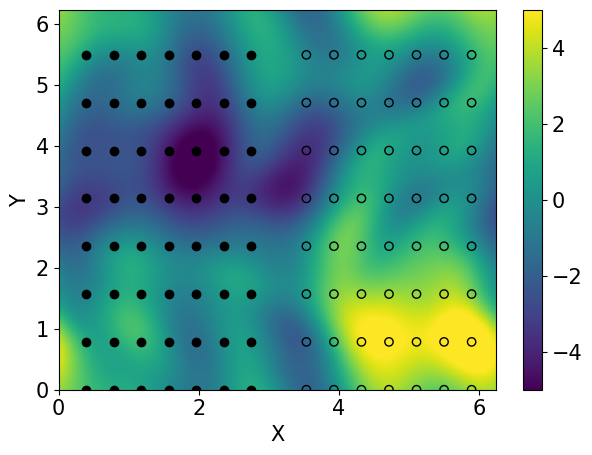

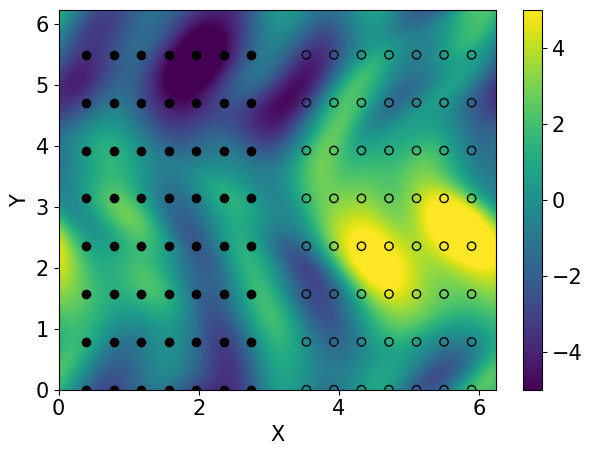

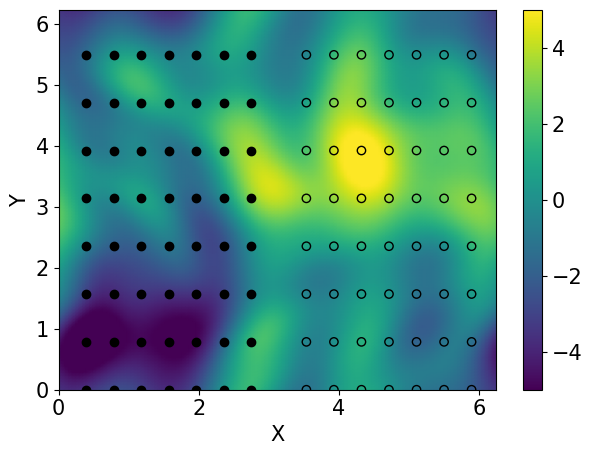

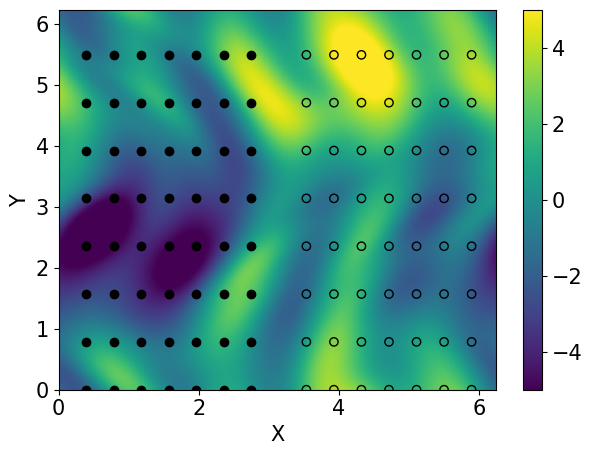

In [8]:
ν = 1.0e-2                                      # viscosity
N, L = 128, 2*pi                                 # resolution and domain size 
ub, vb = 0.0, 2*pi                        # background velocity 
method="Crank-Nicolson"                         # RK4 or Crank-Nicolson
N_t = 2500;                                     # time step
T = 0.5;                                        # final time
obs_ΔNx, obs_ΔNy, obs_ΔNt = 8, 16, 1250         # observation
symmetric = true
σ_0 = sqrt(2)*pi
N_KL = 128
N_θ = 128

seed=22
Random.seed!(seed);

mesh = Spectral_Mesh(N, N, L, L)
s_param = Setup_Param(ν, ub, vb,  
    N, L,  
    method, N_t,
    obs_ΔNx, obs_ΔNy, obs_ΔNt; 
    symmetric = symmetric,
    N_ω0_θ = N_θ,
    N_ω0_ref = N_KL,
    f = (x, y) -> (0, cos(4*x)),
    σ = σ_0,
    ω0_seed=seed)
ω0_ref = s_param.ω0_ref
ω0_ref_mirror = -ω0_ref[[1;end:-1:2], :]
# generate observation data
y_noiseless = forward_helper(s_param, ω0_ref; symmetric=true, save_file_name="NS", vmin=-5.0, vmax=5.0);
y_noiseless_mirror = forward_helper(s_param, ω0_ref_mirror; symmetric=true, save_file_name="NS_mirror", vmin=-5.0, vmax=5.0);
@info "y - y_mirror = ", norm(y_noiseless - y_noiseless_mirror)

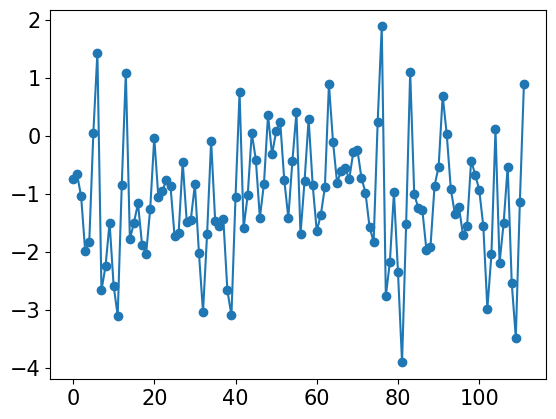

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2c73c9ba0>

In [4]:
plot(y_noiseless, "-o")

## Gaussian Mixture Kalman Inversion

The GMKI is initialized with $\theta_0 \sim \mathcal{N}(0, 10I)$ and the observation 
error assumed for inversion purposes is $\eta \sim \mathcal{N}(0, I)$. And this problem 
is insensitive to the observation error, and the results obtained with $\alpha = 1$ (no regularization) 
are presented.




In [5]:
# compute posterior distribution by GMKI
N_iter =50
update_freq = 1
N_modes = 3
θ0_w  = fill(1.0, N_modes)/N_modes



θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)
for i = 1:N_modes
    θ0_mean[i, :]    .= rand(Normal(0, σ_0), N_θ) 
    θθ0_cov[i, :, :] .= Array(Diagonal(fill(1.0^2, N_θ)))
end
μ_0 = zeros(Float64, N_θ)  # prior/initial mean 
Σ_0 = Array(Diagonal(fill(σ_0^2, N_θ)))  # prior/initial covariance


σ_η = 0.1
N_y = length(y_noiseless)
y = y_noiseless + rand(Normal(0, σ_η), N_y)
Σ_η = Array(Diagonal(fill(σ_η^2, N_y)))


### Augment the system
aug_y = [y; μ_0]
aug_Σ_η = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ_0]  
s_param.N_y = length(aug_y)


γ = 1.0
Δt = γ/(1+γ)
# @time gmkiiobj = GMKI_Run(s_param, aug_forward, θ0_w, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, Δt, update_freq, N_iter; unscented_transform="modified-2n+1")
# @save "gmkiobj.jld2" gmkiobj



0.5

In [10]:
@load "gmkiobj-seed22.jld2" gmkiobj

┌ Warning: type JLD2.ReconstructedTypes.##Main.GMUKIObj{Float64,Int64}#275 does not exist in workspace; reconstructing
└ @ JLD2 /Users/huang/.julia/packages/JLD2/AilrO/src/data/reconstructing_datatypes.jl:456


1-element Vector{Symbol}:
 :gmkiobj

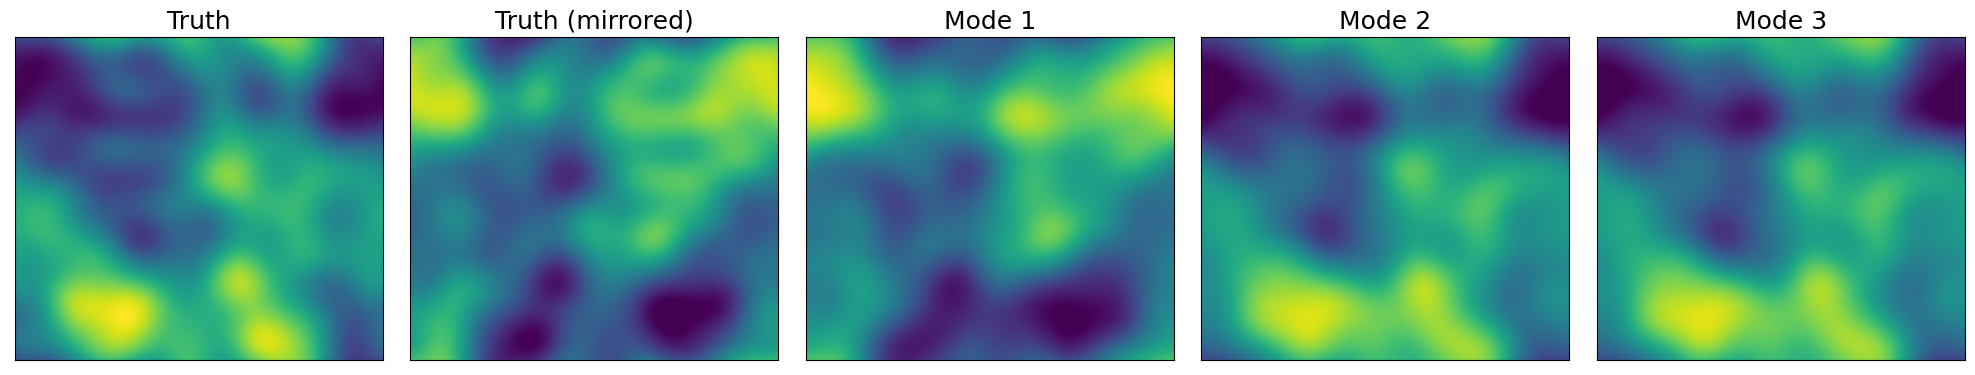

In [11]:
function plot_field(mesh::Spectral_Mesh, grid_dat::Array{Float64,2}, clim, ax; cmap="viridis")
    
    N_x, N_y = mesh.N_x, mesh.N_y
    xx, yy = mesh.xx, mesh.yy
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    
    return ax.pcolormesh(X, Y, grid_dat, shading= "gouraud", clim=clim, cmap=cmap)
end


N_ens = 2N_θ + 1
# visulize the log permeability field
fig_vor, ax_vor = PyPlot.subplots(ncols = 5, sharex=true, sharey=true, figsize=(20,4))
for ax in ax_vor ;  ax.set_xticks([]) ; ax.set_yticks([]) ; end
color_lim = (minimum(s_param.ω0_ref), maximum(s_param.ω0_ref))

plot_field(mesh, s_param.ω0_ref, color_lim, ax_vor[1]) 
ax_vor[1].set_title("Truth")

plot_field(mesh, -s_param.ω0_ref[[1;end:-1:2], :], color_lim, ax_vor[2]) 
ax_vor[2].set_title("Truth (mirrored)")

grid_vor = Random_Field_From_Theta(mesh, gmkiobj.θ_mean[N_iter][1,:], s_param.seq_pairs)   
plot_field(mesh, grid_vor,  color_lim, ax_vor[3]) 
ax_vor[3].set_title("Mode 1")

grid_vor = Random_Field_From_Theta(mesh, gmkiobj.θ_mean[N_iter][2,:], s_param.seq_pairs)   
plot_field(mesh, grid_vor,  color_lim, ax_vor[4]) 
ax_vor[4].set_title("Mode 2")

grid_vor = Random_Field_From_Theta(mesh, gmkiobj.θ_mean[N_iter][3,:], s_param.seq_pairs)   
plot_field(mesh, grid_vor,  color_lim, ax_vor[5]) 
ax_vor[5].set_title("Mode 3")


fig_vor.tight_layout()
fig_vor.savefig("NS-2D-vor.pdf")







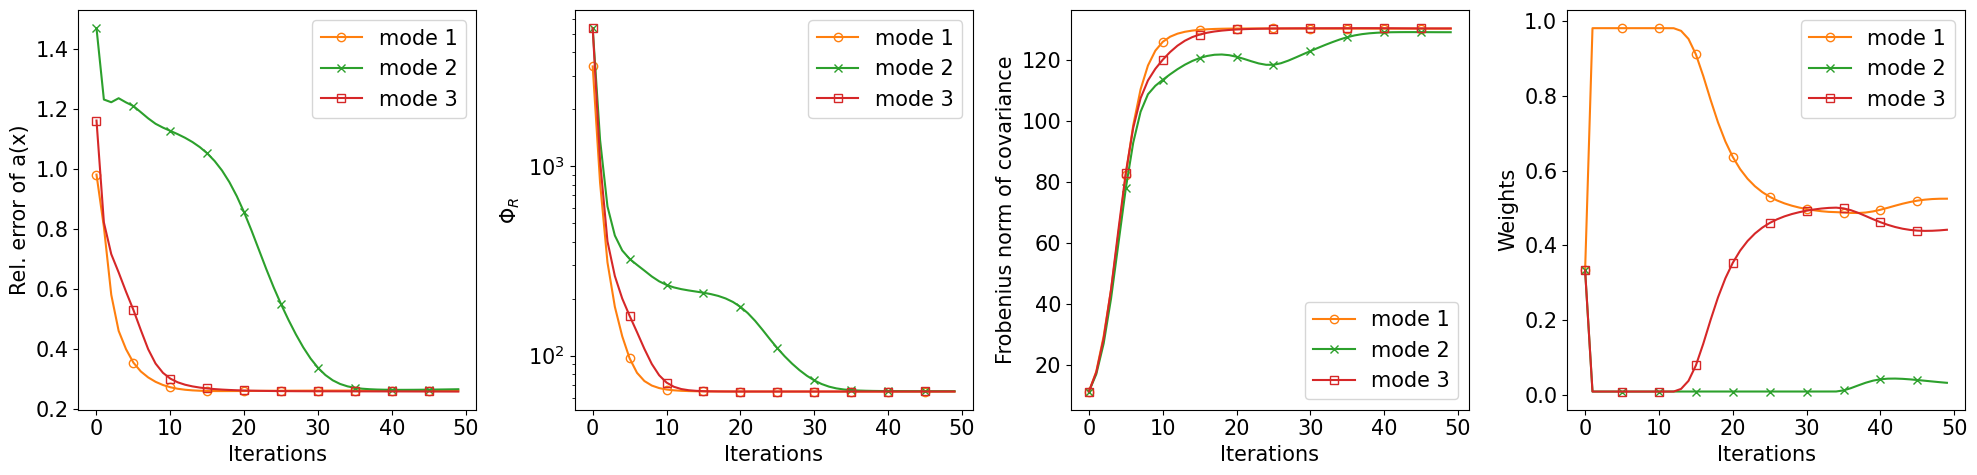

In [14]:
N_ens = 2N_θ + 1
fig, (ax1, ax2, ax3, ax4) = PyPlot.subplots(ncols=4, figsize=(20,5))
ites = Array(LinRange(0, N_iter-1, N_iter))
errors = zeros(Float64, (3, N_iter, N_modes))

for m = 1:N_modes
    for i = 1:N_iter
        if m in [2,3]
            grid_vor_truth = s_param.ω0_ref
        else
            grid_vor_truth = -s_param.ω0_ref[[1;end:-1:2], :]
        end
        
        grid_vor = Random_Field_From_Theta(mesh, gmkiobj.θ_mean[i][m,:], s_param.seq_pairs)   

        errors[1, i, m] = norm(grid_vor_truth - grid_vor)/norm(grid_vor_truth)
        errors[2, i, m] = 0.5*(gmkiobj.y_pred[i][m,:] - gmkiobj.y)'*(gmkiobj.Σ_η\(gmkiobj.y_pred[i][m,:] - gmkiobj.y))
        errors[3, i, m] = norm(gmkiobj.θθ_cov[i][m,:,:])
    end
end

linestyles = ["o"; "x"; "s"]
markevery = 5
for m = 1: N_modes
    ax1.plot(ites, errors[1, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Rel. error of a(x)")
ax1.legend()

for m = 1: N_modes
    ax2.semilogy(ites, errors[2, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax2.set_xlabel("Iterations")
ax2.set_ylabel(L"\Phi_R")
ax2.legend()

for m = 1: N_modes
    ax3.plot(ites, errors[3, :, m], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.legend()


θ_w = exp.(hcat(gmkiobj.logθ_w...))
for m = 1: N_modes
    ax4.plot(ites, θ_w[m, 1:N_iter], marker=linestyles[m], color = "C"*string(m), fillstyle="none", markevery=markevery, label= "mode "*string(m))
end
ax4.set_xlabel("Iterations")
ax4.set_ylabel("Weights")
ax4.legend()
fig.tight_layout()
fig.savefig("NS-2D-convergence.pdf")




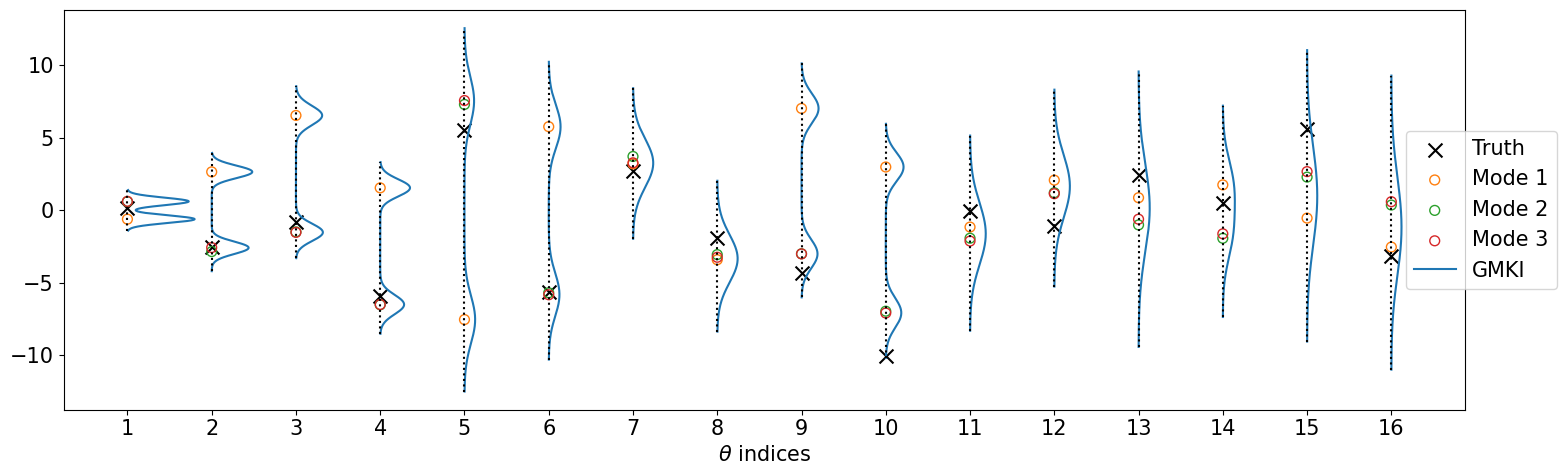

In [17]:
fig, ax = PyPlot.subplots(ncols=1, figsize=(16,5))
θ_ref = s_param.θ_ref

n_ind = 16
θ_ind = Array(1:n_ind)
ax.scatter(θ_ind, θ_ref[θ_ind], s = 100, marker="x", color="black", label="Truth")
for m = 1:N_modes
    ax.scatter(θ_ind, gmkiobj.θ_mean[N_iter][m,θ_ind], s = 50, marker="o", color="C"*string(m), facecolors="none", label="Mode "*string(m))
end

Nx = 1000
for i in θ_ind
    θ_min = minimum(gmkiobj.θ_mean[N_iter][:,i] .- 3sqrt.(gmkiobj.θθ_cov[N_iter][:,i,i]))
    θ_max = maximum(gmkiobj.θ_mean[N_iter][:,i] .+ 3sqrt.(gmkiobj.θθ_cov[N_iter][:,i,i]))
        
    xxs = zeros(N_modes, Nx)  
    zzs = zeros(N_modes, Nx)  
    for m =1:N_modes
        xxs[m, :], zzs[m, :] = Gaussian_1d(gmkiobj.θ_mean[N_iter][m,i], gmkiobj.θθ_cov[N_iter][m,i,i], Nx, θ_min, θ_max)
        zzs[m, :] *= exp(gmkiobj.logθ_w[N_iter][m])
    end
    label = nothing
    if i == 1
        label = "GMKI"
    end
    ax.plot(sum(zzs, dims=1)' .+ i, xxs[1,:], linestyle="-", color="C0", fillstyle="none", label=label)
    ax.plot(fill(i, Nx), xxs[1,:], linestyle=":", color="black", fillstyle="none")
        
end
ax.set_xticks(θ_ind)
ax.set_xlabel(L"\theta" * " indices")
ax.legend(loc="center left", bbox_to_anchor=(0.95, 0.5))
fig.tight_layout()
fig.savefig("NS-2D-density.pdf")

